<h1 align="center">Audio_Proc</h1>

<h5 align="right">@aiskido</h5>

<h3>Importing packages</h3>

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import librosa
import librosa.display

from scipy.io import wavfile
import scipy.io.wavfile as sci_wav
import IPython.display as ipd

import torchaudio
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import nn
from torchsummary import summary

<h3>The data</h3>

For this task we decided to take dataset called "<a href="https://www.kaggle.com/datasets/emrahaydemr/gunshot-audio-dataset">Guns</a>".

In [2]:
data = pd.DataFrame()

In [3]:
LIst = list()
List2 = []
List3 = []
for i in os.listdir('guns/AA/'):
    LIst.append(i)
    words = i.split(' ')
    List3.append(int(words[0])-1)
    if words[0] == '1':
        List2.append('AK-47')
    elif words[0] == '2':
        List2.append('Desert Eagle')
    elif words[0] == '3':
        List2.append('AK-12')
    elif words[0] == '4':
        List2.append('M4')
    elif words[0] == '5':
        List2.append('M16')
    elif words[0] == '6':
        List2.append('M249')
    elif words[0] == '7':
        List2.append('MG-42')
    elif words[0] == '8':
        List2.append('MP5')
    else:
        List2.append('Zastava M92')
data['file_name'] = LIst
data['class'] = List2
data['classID'] = List3
data

,file_name,class,classID
0,1 (1).wav,AK-47,0
1,1 (10).wav,AK-47,0
2,1 (11).wav,AK-47,0
3,1 (12).wav,AK-47,0
4,1 (13).wav,AK-47,0
...,...,...,...
846,9 (8).wav,Zastava M92,8
847,9 (80).wav,Zastava M92,8
848,9 (81).wav,Zastava M92,8
849,9 (82).wav,Zastava M92,8


<h4>Audio example</h4>

Sample work with one of them '1 (66).wav'

In [4]:
path = 'guns/AA/1 (66).wav'

In [5]:
ipd.Audio(path)

In [6]:
x, sr = librosa.load(path)

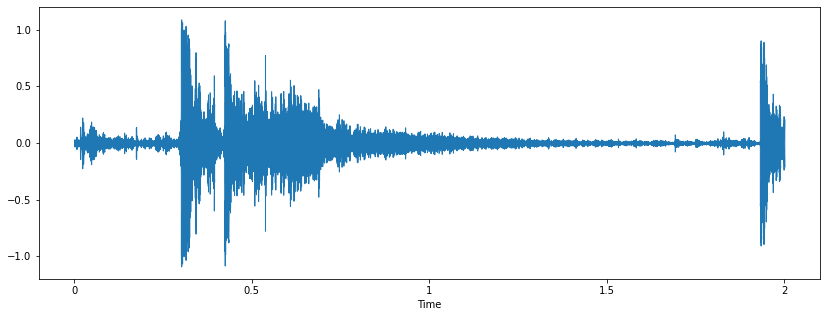

In [7]:
plt.figure(figsize=(14, 5))
librosa.display.waveshow(x, sr=sr)

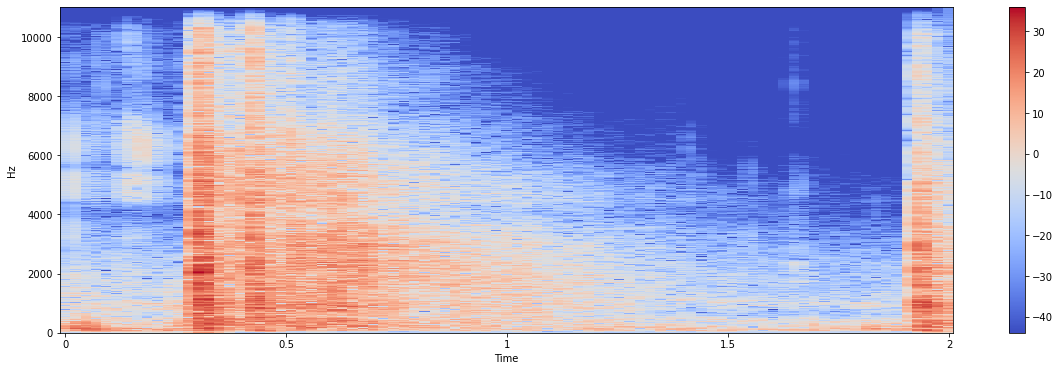

In [8]:
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(20, 6))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()

<h3>Data working</h3>

Working with dataset

In [9]:
class GunsDataset(Dataset):

    def __init__(self,
                 annotations_file,
                 audio_dir,
                 transformation,
                 target_sample_rate,
                 num_samples,
                 device):
        self.annotations = annotations_file
        self.audio_dir = audio_dir
        self.device = device
        self.transformation = transformation.to(self.device)
        self.target_sample_rate = target_sample_rate
        self.num_samples = num_samples

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        audio_sample_path = self._get_audio_sample_path(index)
        label = self._get_audio_sample_label(index)
        signal, sr = torchaudio.load(audio_sample_path)
        signal = signal.to(self.device)
        signal = self._resample_if_necessary(signal, sr)
        signal = self._mix_down_if_necessary(signal)
        signal = self._cut_if_necessary(signal)
        signal = self._right_pad_if_necessary(signal)
        signal = self.transformation(signal)
        return signal, label

    def _cut_if_necessary(self, signal):
        if signal.shape[1] > self.num_samples:
            signal = signal[:, :self.num_samples]
        return signal

    def _right_pad_if_necessary(self, signal):
        length_signal = signal.shape[1]
        if length_signal < self.num_samples:
            num_missing_samples = self.num_samples - length_signal
            last_dim_padding = (0, num_missing_samples)
            signal = torch.nn.functional.pad(signal, last_dim_padding)
        return signal

    def _resample_if_necessary(self, signal, sr):
        if sr != self.target_sample_rate:
            resampler = torchaudio.transforms.Resample(sr, self.target_sample_rate)
            signal = resampler(signal)
        return signal

    def _mix_down_if_necessary(self, signal):
        if signal.shape[0] > 1:
            signal = torch.mean(signal, dim=0, keepdim=True)
        return signal

    def _get_audio_sample_path(self, index):
        path = os.path.join(self.audio_dir, self.annotations.iloc[
            index, 0])
        return path

    def _get_audio_sample_label(self, index):
        return self.annotations.iloc[index, 2]

<hr>

CNN network

In [10]:
class CNNNetwork(nn.Module):

    def conv_block(self, in_feat, out_feat, kernel_size, stride, padding):
        # Convolution Block with Relu and Batch Norm. Use Kaiming Initialization
        conv_layer = []
        conv = nn.Conv2d(in_feat, out_feat, kernel_size=kernel_size, stride=stride, padding=padding)
        relu = nn.ReLU()
        bn = nn.BatchNorm2d(out_feat)
        nn.init.kaiming_normal_(conv.weight, a=0.1)
        conv.bias.data.zero_()
        conv_layer += [conv, relu, bn]
        return conv_layer

    def __init__(self):
        super().__init__()
        block1 = self.conv_block(1, 16, kernel_size=(5, 5), stride=(3, 3), padding=(2, 2))
        block2 = self.conv_block(16, 32, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
        block3 = self.conv_block(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        block4 = self.conv_block(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))

        conv_layers = block1 + block2 + block3 + block4

        # Wrap the Convolutional Blocks
        self.conv = nn.Sequential(*conv_layers)

        # Linear Classifier
        self.ap = nn.AdaptiveAvgPool2d(output_size=1)
        self.lin = nn.Linear(in_features=128, out_features=10)

    def forward(self, x):
        x = self.conv(x)
        x = self.ap(x)  # adaptive pool
        x = x.view(x.shape[0], -1)  # flatten
        x = self.lin(x)  # linear layer
        return x

<hr>

<h3>Training</h3>

In [12]:
ANNOTATIONS_FILE = data
AUDIO_DIR = "guns/AA"

In [13]:
BATCH_SIZE = 128
EPOCHS = 10
LEARNING_RATE = 0.001

In [14]:
SAMPLE_RATE = 22050
NUM_SAMPLES = 22050

In [15]:
if __name__ == "__main__":
    if torch.cuda.is_available():
        device = "cuda"
    else:
        device = "cpu"
    print(f"Using {device}")

    # instantiating our dataset object and create data loader
    mel_spectrogram = torchaudio.transforms.MelSpectrogram(
        sample_rate=SAMPLE_RATE,
        n_fft=1024,
        hop_length=512,
        n_mels=64
    )

    guns = GunsDataset(ANNOTATIONS_FILE,
                            AUDIO_DIR,
                            mel_spectrogram,
                            SAMPLE_RATE,
                            NUM_SAMPLES,
                            device)
    
    # Split dataset into train and test
    train, test = torch.utils.data.random_split(guns, [681, 170], generator=torch.Generator().manual_seed(0))

    # data loader
    train_dataloader = torch.utils.data.DataLoader(train, batch_size = BATCH_SIZE, shuffle = False)
    test_dataloader = torch.utils.data.DataLoader(test, batch_size = BATCH_SIZE, shuffle = False)
#     train_dataloader = create_data_loader(guns, BATCH_SIZE)

    # construct model and assign it to device
    cnn = CNNNetwork().to(device)
    print(cnn)

    # initialise loss funtion + optimiser
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(cnn.parameters(),
                                 lr=LEARNING_RATE)

    # train model
    count = 0
    loss_list = []
    iteration_list = []
    accuracy_list = []


    for epoch in range(EPOCHS):
        for i, (train_features, train_target) in enumerate(train_dataloader):
            train_features, train_target = train_features.to(torch.device(device)), train_target.to(torch.device(device))
        
            # Clear gradients
            optimizer.zero_grad()
        
            # Forward propagation
            prediction = cnn(train_features)
            
            # Calculate softmax and ross entropy loss
            loss = loss_fn(prediction, train_target)
        
            # Calculating gradients
            loss.backward()
        
            # Update parameters
            optimizer.step()
            
            count += 1
            
            if count % 50 == 0:
                # Calculate Accuracy         
                correct = 0
                total = 0
            
                # Iterate through test dataset
                for test_features, test_target in train_dataloader:
                    test_features, test_target = test_features.to(torch.device(device)), test_target.to(torch.device(device))
                
                    # Forward propagation
                    prediction = cnn(test_features)
                
                    # Get predictions from the maximum value
                    predicted = torch.max(prediction.data, 1)[1]
                
                    # Total number of labels
                    total += len(test_target)
                
                    correct += (predicted == test_target).sum()
            
                accuracy = 100 * correct / float(total)
            
                # store loss and iteration
                loss_list.append(loss.data)
                iteration_list.append(count)
                accuracy_list.append(accuracy)
            
            if count % 100 == 0:
                # Print Loss
                print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(count, loss.data, accuracy))

    # save model
    torch.save(cnn.state_dict(), "cnnnet.pth")
    print("Trained feed forward net saved at cnnnet.pth")

Using cpu
CNNNetwork(
  (conv): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(3, 3), padding=(2, 2))
    (1): ReLU()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (10): ReLU()
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (ap): AdaptiveAvgPool2d(output_size=1)
  (lin): Linear(in_features=128, out_features=10, bias=True)
)
Trained feed forward net saved at cnnnet.pth


<h3>Prediction</h3>

In [16]:
class_mapping = data['class'].unique()

In [17]:
def predict(model, input, target, class_mapping):
    model.eval()
    with torch.no_grad():
        predictions = model(input)
        # Tensor (1, 10) -> [ [0.1, 0.01, ..., 0.6] ]
        predicted_index = predictions[0].argmax(0)
        predicted = class_mapping[predicted_index]
        expected = class_mapping[target]
    return predicted, expected

In [18]:
cnn = CNNNetwork()
state_dict = torch.load("cnnnet.pth")
cnn.load_state_dict(state_dict)

mel_spectrogram = torchaudio.transforms.MelSpectrogram(
    sample_rate=SAMPLE_RATE,
    n_fft=1024,
    hop_length=512,
    n_mels=64
)

guns = GunsDataset(ANNOTATIONS_FILE,
                    AUDIO_DIR,
                    mel_spectrogram,
                    SAMPLE_RATE,
                    NUM_SAMPLES,
                    device)
# input, target = cad[0][0], cad[0][1]
# input, target = data1.iloc[:, 0], data1.iloc[:, 1]
count = 0
for i in range(len(guns)):
    input, target = guns[i][0], guns[i][1]
    input.unsqueeze_(0)
    predicted, expected = predict(cnn, input, target,
                            class_mapping)
    print(f"Predicted: '{predicted}', expected: '{expected}'")
    if predicted == expected:
        count += 1
print('Accuracy:', count/len(guns))

Predicted: 'AK-47', expected: 'AK-47'
Predicted: 'AK-47', expected: 'AK-47'
Predicted: 'AK-47', expected: 'AK-47'
Predicted: 'AK-47', expected: 'AK-47'
Predicted: 'AK-47', expected: 'AK-47'
Predicted: 'M16', expected: 'AK-47'
Predicted: 'M16', expected: 'AK-47'
Predicted: 'AK-47', expected: 'AK-47'
Predicted: 'AK-47', expected: 'AK-47'
Predicted: 'AK-47', expected: 'AK-47'
Predicted: 'AK-47', expected: 'AK-47'
Predicted: 'M16', expected: 'AK-47'
Predicted: 'AK-47', expected: 'AK-47'
Predicted: 'AK-47', expected: 'AK-47'
Predicted: 'AK-47', expected: 'AK-47'
Predicted: 'AK-47', expected: 'AK-47'
Predicted: 'AK-47', expected: 'AK-47'
Predicted: 'AK-47', expected: 'AK-47'
Predicted: 'AK-47', expected: 'AK-47'
Predicted: 'AK-47', expected: 'AK-47'
Predicted: 'AK-47', expected: 'AK-47'
Predicted: 'AK-47', expected: 'AK-47'
Predicted: 'AK-47', expected: 'AK-47'
Predicted: 'AK-47', expected: 'AK-47'
Predicted: 'AK-47', expected: 'AK-47'
Predicted: 'AK-47', expected: 'AK-47'
Predicted: 'AK-47'

Predicted: 'AK-12', expected: 'AK-12'
Predicted: 'AK-12', expected: 'AK-12'
Predicted: 'AK-12', expected: 'AK-12'
Predicted: 'AK-12', expected: 'AK-12'
Predicted: 'AK-12', expected: 'AK-12'
Predicted: 'AK-12', expected: 'AK-12'
Predicted: 'AK-12', expected: 'AK-12'
Predicted: 'AK-12', expected: 'AK-12'
Predicted: 'AK-12', expected: 'AK-12'
Predicted: 'AK-12', expected: 'AK-12'
Predicted: 'MP5', expected: 'AK-12'
Predicted: 'AK-12', expected: 'AK-12'
Predicted: 'AK-12', expected: 'AK-12'
Predicted: 'AK-12', expected: 'AK-12'
Predicted: 'AK-12', expected: 'AK-12'
Predicted: 'AK-12', expected: 'AK-12'
Predicted: 'AK-12', expected: 'AK-12'
Predicted: 'M16', expected: 'AK-12'
Predicted: 'AK-12', expected: 'AK-12'
Predicted: 'AK-12', expected: 'AK-12'
Predicted: 'AK-12', expected: 'AK-12'
Predicted: 'AK-12', expected: 'AK-12'
Predicted: 'AK-12', expected: 'AK-12'
Predicted: 'AK-12', expected: 'AK-12'
Predicted: 'AK-12', expected: 'AK-12'
Predicted: 'AK-12', expected: 'AK-12'
Predicted: 'AK-1

Predicted: 'M4', expected: 'M16'
Predicted: 'M16', expected: 'M16'
Predicted: 'M4', expected: 'M16'
Predicted: 'MP5', expected: 'M16'
Predicted: 'M16', expected: 'M16'
Predicted: 'M16', expected: 'M16'
Predicted: 'M4', expected: 'M16'
Predicted: 'M249', expected: 'M16'
Predicted: 'M4', expected: 'M16'
Predicted: 'M4', expected: 'M16'
Predicted: 'M4', expected: 'M16'
Predicted: 'M4', expected: 'M16'
Predicted: 'M16', expected: 'M16'
Predicted: 'M16', expected: 'M16'
Predicted: 'M4', expected: 'M16'
Predicted: 'M16', expected: 'M16'
Predicted: 'M16', expected: 'M16'
Predicted: 'M249', expected: 'M16'
Predicted: 'M249', expected: 'M16'
Predicted: 'M16', expected: 'M16'
Predicted: 'M4', expected: 'M16'
Predicted: 'M16', expected: 'M16'
Predicted: 'M4', expected: 'M16'
Predicted: 'M4', expected: 'M16'
Predicted: 'M16', expected: 'M16'
Predicted: 'M16', expected: 'M16'
Predicted: 'M4', expected: 'M16'
Predicted: 'M249', expected: 'M16'
Predicted: 'MP5', expected: 'M16'
Predicted: 'M249', exp

Predicted: 'M16', expected: 'MG-42'
Predicted: 'MG-42', expected: 'MG-42'
Predicted: 'MG-42', expected: 'MG-42'
Predicted: 'MG-42', expected: 'MG-42'
Predicted: 'MG-42', expected: 'MG-42'
Predicted: 'MG-42', expected: 'MG-42'
Predicted: 'MG-42', expected: 'MG-42'
Predicted: 'MG-42', expected: 'MG-42'
Predicted: 'MG-42', expected: 'MG-42'
Predicted: 'MG-42', expected: 'MG-42'
Predicted: 'MG-42', expected: 'MG-42'
Predicted: 'MP5', expected: 'MP5'
Predicted: 'M16', expected: 'MP5'
Predicted: 'MP5', expected: 'MP5'
Predicted: 'M16', expected: 'MP5'
Predicted: 'M16', expected: 'MP5'
Predicted: 'M16', expected: 'MP5'
Predicted: 'MP5', expected: 'MP5'
Predicted: 'MP5', expected: 'MP5'
Predicted: 'MP5', expected: 'MP5'
Predicted: 'MP5', expected: 'MP5'
Predicted: 'MP5', expected: 'MP5'
Predicted: 'MP5', expected: 'MP5'
Predicted: 'M16', expected: 'MP5'
Predicted: 'M4', expected: 'MP5'
Predicted: 'MP5', expected: 'MP5'
Predicted: 'MP5', expected: 'MP5'
Predicted: 'MP5', expected: 'MP5'
Predict